## 0- import Section 📚

In [33]:
#region imports
import pandas as pd
import numpy as np
import missingno as msno
import random
import re
from nltk import word_tokenize
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from tensorflow.keras import Sequential,layers
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import cross_val_score,KFold,train_test_split
from xgboost import XGBRegressor
import lightgbm as lgbm
from sklearn.ensemble import BaggingRegressor

rand_state=100
RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
#endregion

#region settings
random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

#endregion

In [34]:
df_awards=pd.read_csv("../data/220k_awards_by_directors.csv")
df_500_fav=pd.read_csv("../data/500 favorite directors_with wikipedia summary.csv", sep=";",header=0,names=['A', 'B'])
df_900_acc=pd.read_csv("../data/900_acclaimed_directors_awards.csv", sep=";")
df_all_casting=pd.read_csv("../data/AllMoviesCastingRaw.csv", sep=";")
df_all_details = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", sep=";",low_memory=False)
df_lan2country_df = pd.read_csv('../data/language to country.csv')
df_most_common_lang=pd.read_csv("../data/MostCommonLanguageByDirector.csv")
df_spliberg=pd.read_csv("../data/spielberg_awards.csv",encoding='latin1')

## 1- define helper methods 📚

In [18]:
def show(df_, rows=20, cols=30, title=None):
    '''
    this utility function, can be passed in a 
    panda's processing chain, to display intermediate
    dataframes.
    '''
    if title:
        display(HTML(f'<h2 >{title}</h2 > '))
        with pd.option_context('display.min_rows', rows, 'display.max_columns', cols):
            display(df_)
    return df_

def get_var(df, var_name):
    '''
    this utility function, can be passed in a 
    panda's processing chain, to store an intermediate
    dataframes into var_names.
    '''
    globals()[var_name] = df
    return df

def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
    return frequency_matrix_count



## 2- Processing 📚

In [51]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp","month"])
    
    )
actors_df=(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
director_df=(#2- extracting director_weights
    df_all_casting 
                .melt(id_vars="id",value_vars=["director_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("NaN",np.NaN)
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .drop(columns=["variable","value","year","unit"])
                .merge(df_all_casting[["id","director_name"]],on="id",how="left")
)

data_awards_cleaned=(
    df_awards
            .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
            .groupby(["director_name", "year","outcome"])
            .count()
            .unstack()
            .fillna(0)
            .reset_index()
            .iloc[:,0:4]
            .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
            .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
                won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
                )
            .set_index(["director_name","year"])
)
    

def fame_func(director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

df=(
    df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","spoken_languages_number"] )
).assign(
    fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year),axis=1),
    fame_won= lambda df_:df_.apply(lambda df_:fame_func(df_.director_name,df_.year,stat=1),axis=1)
    
).drop(columns=["director_name","fiction","year"] )


df_nulls=df.replace(-999,np.NAN)
df

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,sin_month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,-5.000000e-01,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,-1.000000e+00,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,8.660254e-01,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,8.660254e-01,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,1.224647e-16,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,-999.0,0,1,1,0.0,8.0,5.000000e-01,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,5.000000e-01,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,-999.0,0,0,1,NaN,-999.0,-9.990000e+02,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,-5.000000e-01,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


## 3- null analysis 📚

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/missingno/missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)


<AxesSubplot:>

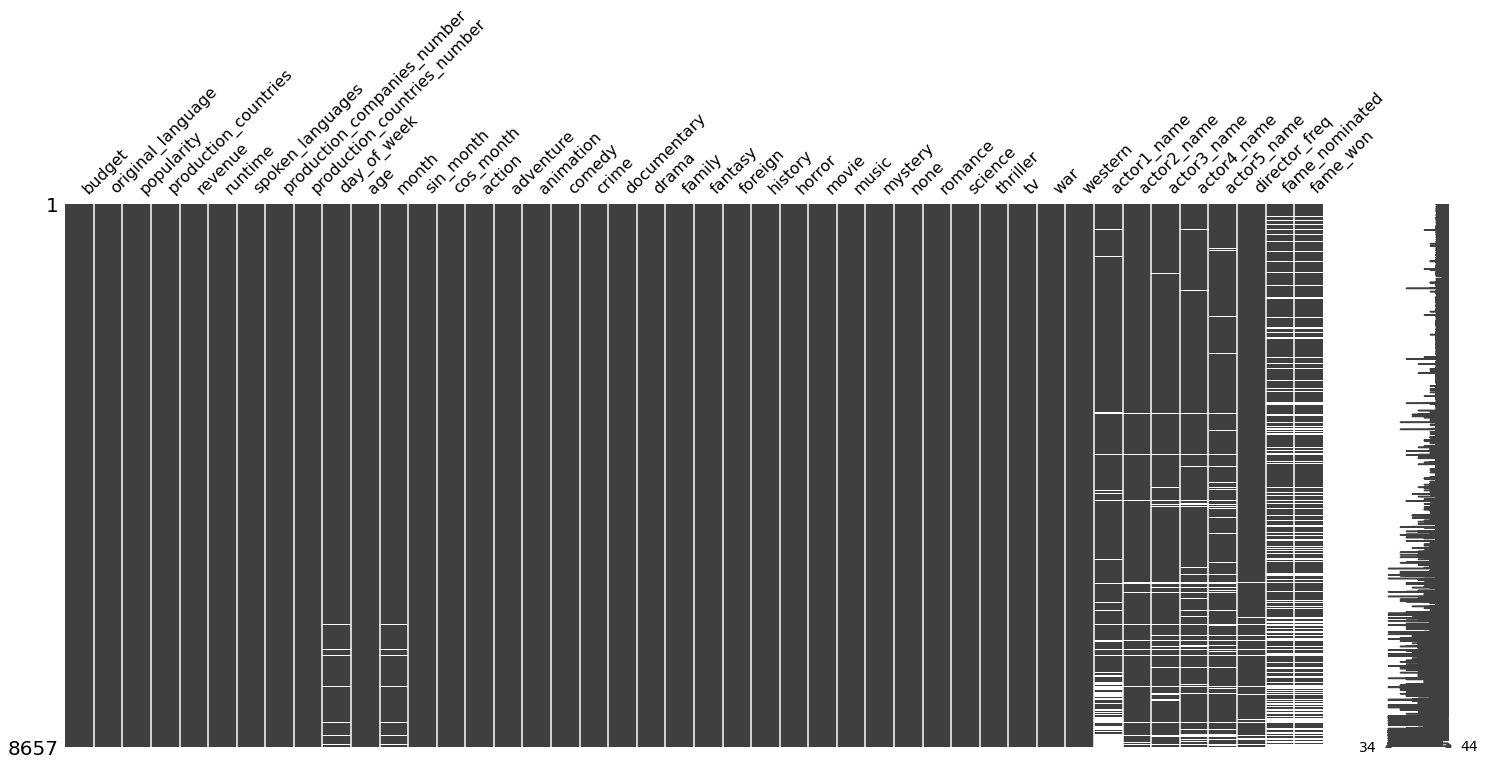

In [36]:
msno.matrix(df) #some nulls are filled fith -999

<AxesSubplot:>

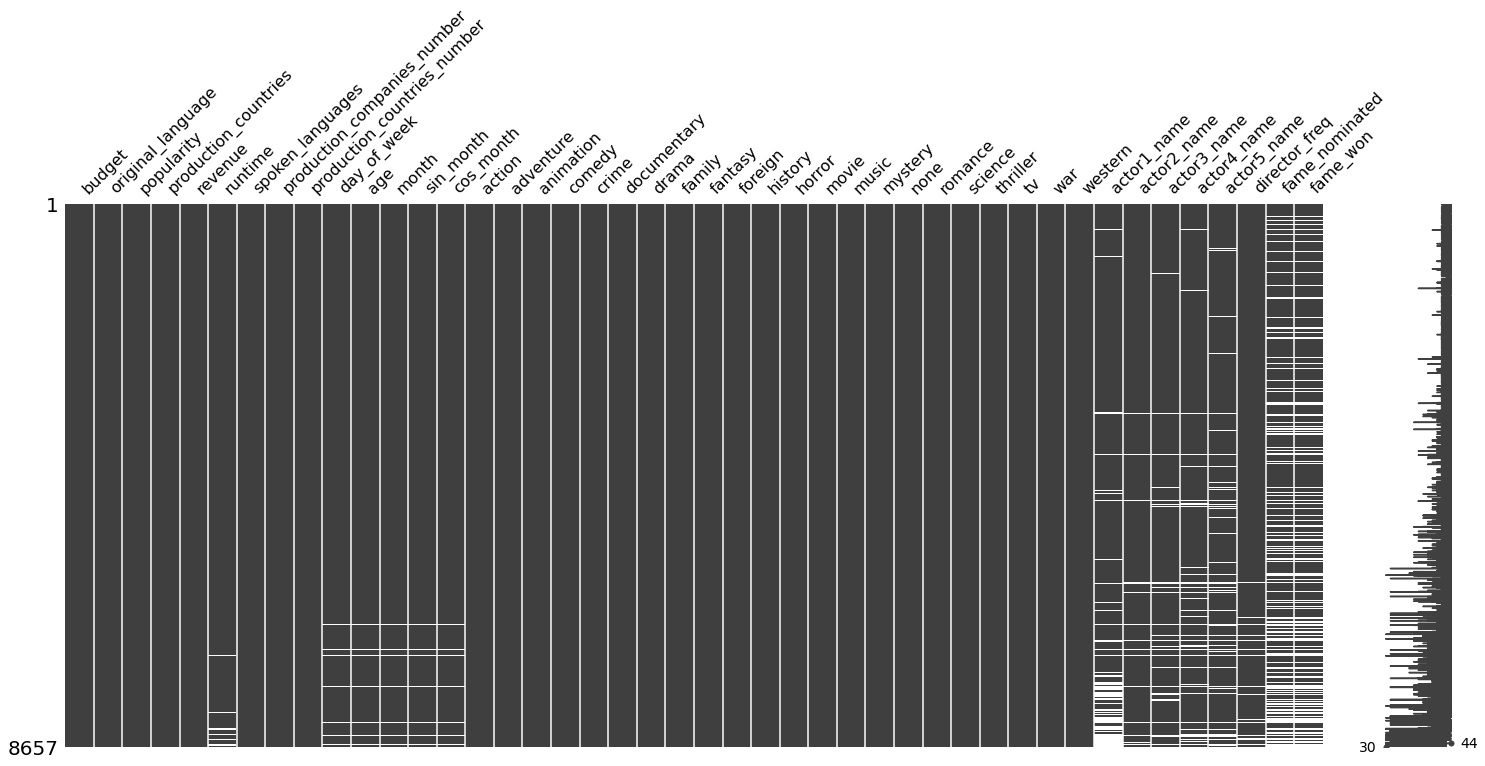

In [37]:
msno.matrix(df_nulls) #nulls are np.NaN 

## 4- defining X,y  📚

In [100]:
X=df_nulls.drop(columns=["revenue","popularity"])
# X=df.drop(columns=["revenue","popularity"])
y=df[["revenue","popularity"]]
target_1=y.iloc[:,0]
target_2=y.iloc[:,1]


## 5- defining pipeline 📚

In [101]:
cat_transformer = Pipeline([
    ("ohc",OneHotEncoder(handle_unknown='ignore'))
    ])
preprocessor = ColumnTransformer([
    ('cat_tr', cat_transformer, ['day_of_week']),
    ('cat_imputer', SimpleImputer(strategy="most_frequent"), ['day_of_week','actor1_name', 'actor2_name', 
                                                            'actor3_name', 'actor4_name', 'actor5_name', 
                                                            'director_freq', 'fame_nominated', 'fame_won']),
    ('imputer',SimpleImputer(strategy="median"),["runtime",'age', 'sin_month', 'cos_month'])

    ],remainder="passthrough")

estimator=Pipeline(
    [
        ("estimator",XGBRegressor(
            max_depth=6,           # maximum depth of each tree - try 2 to 10
            learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
            n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
            min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
            colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
            subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
            reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
            reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
            num_parallel_tree=1,   # set > 1 for boosted random forests
        ))
        # ("estimator",lgbm.LGBMRegressor())
        # ("estimator",random_search.best_estimator_)
    ]
)

m=Pipeline([
        ('preprocessor',preprocessor),
        # ('imputer',KNNImputer()),
        ('scaler',StandardScaler()),
        ("estimator",estimator)
        
    ])
m

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_tr',
                                                  Pipeline(steps=[('ohc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week']),
                                                 ('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['day_of_week', 'actor1_name',
                                                   'actor2_name', 'actor3_name',
                                                   'actor4_name', 'actor5_name',
                                                   'director_freq',
                                                   'fame_nominate...
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.01,
                                               max_delta_step=None, max_depth=6,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=1000, n_jobs=None,
                                               num_parallel_tree=1,
                                               predictor=None,
                                               random_state=None, reg_alpha=0.5,
                                               reg_lambda=1.0,
                                               scale_pos_weight=None,
                                               subsample=0.7, tree_method=None,
                                               validate_parameters=None,
                                               verbosity=None))]))])

In [107]:
X_processed=pd.DataFrame(preprocessor.fit_transform(X),columns=preprocessor.get_feature_names_out())

In [108]:
X_processed.head()

,cat_tr__day_of_week_0.0,cat_tr__day_of_week_1.0,cat_tr__day_of_week_2.0,cat_tr__day_of_week_3.0,cat_tr__day_of_week_4.0,cat_tr__day_of_week_5.0,cat_tr__day_of_week_6.0,cat_tr__day_of_week_nan,cat_imputer__day_of_week,cat_imputer__actor1_name,cat_imputer__actor2_name,cat_imputer__actor3_name,...,remainder__history,remainder__horror,remainder__movie,remainder__music,remainder__mystery,remainder__none,remainder__romance,remainder__science,remainder__thriller,remainder__tv,remainder__war,remainder__western
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 6- cross validation and Bagging Regressor 📚

In [102]:
#cross validation
kf=KFold(n_splits=5,random_state=1,shuffle=True)


In [103]:

cross_val_score(m, X, y.iloc[:,0], cv=kf)

array([0.61052075, 0.67060725, 0.58919504, 0.64047588, 0.57696868])

In [104]:
np.round(_.mean(),2)

0.62

In [88]:
#Bagging regressor
reg=BaggingRegressor(base_estimator=estimator,n_estimators=5,max_features=25,random_state=0,bootstrap_features=True)

In [89]:
cross_val_score(reg, X, y.iloc[:,0], cv=kf)

array([0.56349621, 0.59643079, 0.57143137, 0.57258301, 0.54730234])

In [90]:
np.round(_.mean(),2)

0.57

In [91]:
# from sklearn.ensemble import AdaBoostRegressor
# reg=AdaBoostRegressor(base_estimator=m,n_estimators=10,random_state=0)
# cross_val_score(reg, , df.dropna()["revenue"], cv=kf)

In [92]:
# np.round(_.mean(),2)

## 7- Benchmarking models 📚

In [15]:
models = []

# model_NN = KerasRegressor(build_fn=create_model, epochs=100, input_size=X.shape[1])
models.append(('DummyRegressor', DummyRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor(random_state=rand_state)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(random_state=rand_state)))
models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))
models.append(('XGBRegressor', XGBRegressor(random_state=rand_state)))
models.append(('LGBMRegressor', lgbm.LGBMRegressor(random_state=rand_state)))

# models.append(('Deep NN', model_NN))
results=[]
names=[]
for name, model in models:

    mod = Pipeline([
        ('preprocessor',preprocessor),
        ('imputer',SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    cv_results = cross_val_score(mod, X, y.iloc[:,0], cv=kf)
    
    results.append(cv_results)
    names.append(name)
    

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+19, tolerance: 1.295e+16
  model = cd_fast.enet_coordinate_descent(
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+19, tolerance: 1.273e+16
  model = cd_fast.enet_coordinate_descent(
/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

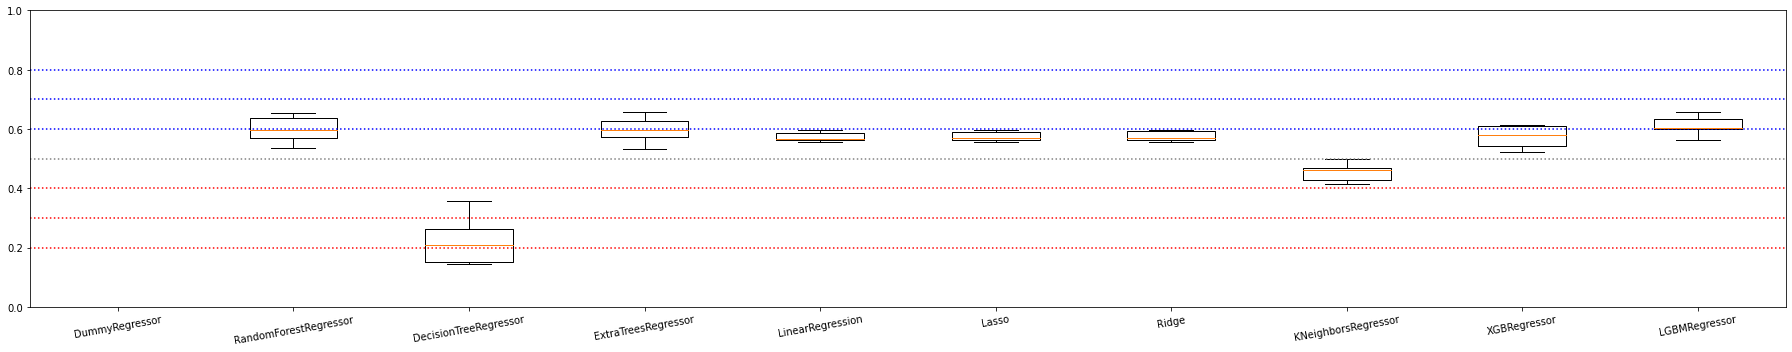

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 5))

ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_xticklabels(names, size=10)
plt.xticks(rotation=10)
plt.ylim([0, 1])
plt.axhline(y=0.8, color='b', linestyle=':')
plt.axhline(y=0.7, color='b', linestyle=':')
plt.axhline(y=0.6, color='b', linestyle=':')
plt.axhline(y=0.5, color='gray', linestyle=':')
plt.axhline(y=0.4, color='r', linestyle=':')
plt.axhline(y=0.3, color='r', linestyle=':')
plt.axhline(y=0.2, color='r', linestyle=':')
plt.tight_layout()
plt.show()

## 8- GridSearch

In [54]:
# from sklearn.model_selection import RandomizedSearchCV
# import time

# # A parameter grid for XGBoost
# params = {
#     'n_estimators':[500,800,1000,1500,2000],
#     'learning_rate':[0.0001,0.001,0.01,0.1],
#     'min_child_weight':[2,4,5,8], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [2,3,4,6,7,10],
#     'objective': ['reg:squarederror', 'reg:tweedie'],
#     'booster': ['gbtree', 'gblinear'],
#     'eval_metric': ['rmse'],
#     'eta': [i/10.0 for i in range(3,6)],
#     'reg_alpha':[0.5,1,5,10],
#     'reg_lambda':[0.5,1,5,10],
#     'num_parallel_tree':[1,5,9]
# }

# reg = XGBRegressor(nthread=-1)

# # run randomized search
# n_iter_search = 50
# random_search = RandomizedSearchCV(reg, param_distributions=params,
#                                    n_iter=n_iter_search, cv=kf, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(X, y.iloc[:,0])
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

`XGBRegressor.best_params_`

{
  'subsample': 1.0,

 'reg_lambda': 10,

 'reg_alpha': 10,

 'objective': 'reg:squarederror',

 'num_parallel_tree': 9,

 'n_estimators': 1500,

 'min_child_weight': 8,

 'max_depth': 7,

 'learning_rate': 0.01,

 'gamma': 0.4,

 'eval_metric': 'rmse',

 'eta': 0.3,

 'colsample_bytree': 0.6,

 'booster': 'gbtree'
 }

In [53]:
# import scipy
# n_estimators=scipy.stats.randint(50,400)
# max_depth=scipy.stats.randint(2,10)
# lambda_l1=np.arange(0,0.8,0.05)
# lambda_l2=np.arange(0,0.8,0.05)
# extra_trees=[True,False]
# subsample=np.arange(0.3,1.0,0.05)
# bagging_freq=scipy.stats.randint(1,100)
# colsample_bytree=np.arange(0.3,1.0,0.05)
# num_leaves=scipy.stats.randint(10,100)
# boosting=['gbdt','dart']
# drop_rate=np.arange(0.1,0.8,0.1)
# skip_drop=np.arange(0,0.7,0.1)
# learning_rate=[0.00001,0.0001,0.001,0.01,0.015,0.02,0.05,0.1,0.15,0.2]
# params = {'n_estimators':n_estimators,'max_depth':max_depth, 'subsample':subsample,
#           'colsample_bytree':colsample_bytree,
#           'learning_rate':learning_rate,
#           'num_leaves':num_leaves,
#           'boosting':boosting,
#           'extra_trees':extra_trees,
#           'lambda_l1':lambda_l1,
#           'lambda_l2':lambda_l2,
#           'bagging_freq':bagging_freq,
#           'drop_rate':drop_rate}

# reg = lgbm.LGBMRegressor(nthread=-1)

# # run randomized search
# n_iter_search = 50
# random_search = RandomizedSearchCV(reg, param_distributions=params,
#                                    n_iter=n_iter_search, cv=kf, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(X, y.iloc[:,0])
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

`random_search.best_params_`  #lgbm

{
  
  'bagging_freq': 1,

 'boosting': 'gbdt',

 'colsample_bytree': 0.5499999999999999,

 'drop_rate': 0.2,

 'extra_trees': True,

 'lambda_l1': 0.4,

 'lambda_l2': 0.75,

 'learning_rate': 0.15,

 'max_depth': 6,

 'n_estimators': 76,

 'num_leaves': 96,

 'subsample': 0.95
 
 }

## 9- TPOT

In [48]:
# from tpot import TPOTRegressor
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,0],
#                                                     train_size=0.75, test_size=0.25, random_state=42)

# tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
# tpot.fit(X_train, y_train)


## 10- Stacking

In [42]:
models = []
# model_NN = KerasRegressor(build_fn=create_model, epochs=100, input_size=X.shape[1])
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(random_state=rand_state)))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
models.append(('XGBRegressor', XGBRegressor(random_state=rand_state)))
models.append(('LGBMRegressor', lgbm.LGBMRegressor(random_state=rand_state)))

In [43]:
estimators=[]

for name, model in models:
    print(name)
    p=Pipeline([
        ('preprocessor',preprocessor),
        ('imputer',SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    estimators.append((name,p))
    

ExtraTreesRegressor
Lasso
Ridge
XGBRegressor
LGBMRegressor


In [46]:
# from sklearn.ensemble import StackingRegressor

# mod = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
# cv_results = cross_val_score(mod, X, target_1, cv=kf)
# cv_results

In [45]:
cv_results.mean()

0.6192891504239801

0.6192891504239801

## 11- Model performance; learning curve 

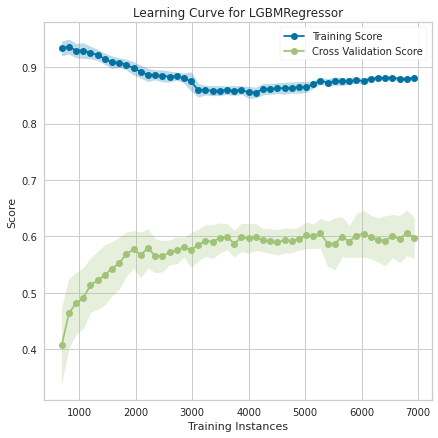

<AxesSubplot:title={'center':'Learning Curve for LGBMRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [57]:
from yellowbrick.model_selection import LearningCurve

# Create an evenly spaced array that will be used as 

sizes = np.linspace(start=0.1, stop=1, num=50)


# Create the learning curve visualizer

lc_viz = LearningCurve(lgbm.LGBMRegressor(), train_sizes=sizes, scoring='r2',cv=kf,size=(500,500))
lc_viz.fit(X, target_1)
lc_viz.show()

## 12- NN

In [105]:
from tensorflow.keras import models
from tensorflow.keras import layers

def initialize_model():
    # $CHALLENGIFY_BEGIN    
    
    model = models.Sequential()
    
    model.add(layers.Dense(10, activation='relu', input_dim = X.shape[-1])) # highly recommend this option
    model.add(layers.Dense(7, activation='relu'))                                 # instead of input_dim = 13
    model.add(layers.Dense(1, activation='linear'))
    
    return model
model = initialize_model()
model.summary()
    # $CHALLENGIFY_END

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 10)                430       
                                                                 
 dense_61 (Dense)            (None, 7)                 77        
                                                                 
 dense_62 (Dense)            (None, 1)                 8         
                                                                 
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [115]:
def compile_model(model, optimizer_name):
    
    # $CHALLENGIFY_BEGIN
    model.compile(loss = 'mse',
                  optimizer = optimizer_name,
                  metrics = 'mse')
    
    return model
    # $CHALLENGIFY_END

Epoch 1/100
138/138 [==============================] - 1s 2ms/step - loss: 23494126091632640.0000 - mse: 23494126091632640.0000 - val_loss: 16297636730503168.0000 - val_mse: 16297636730503168.0000
Epoch 2/100
138/138 [==============================] - 0s 2ms/step - loss: 22242456657461248.0000 - mse: 22242456657461248.0000 - val_loss: 16895455375917056.0000 - val_mse: 16895455375917056.0000
Epoch 3/100
138/138 [==============================] - 0s 2ms/step - loss: 21942083824648192.0000 - mse: 21942083824648192.0000 - val_loss: 17395115765006336.0000 - val_mse: 17395115765006336.0000
Epoch 4/100
138/138 [==============================] - 0s 2ms/step - loss: 21923669152366592.0000 - mse: 21923669152366592.0000 - val_loss: 17332780757155840.0000 - val_mse: 17332780757155840.0000
Epoch 5/100
138/138 [==============================] - 0s 2ms/step - loss: 21927727896461312.0000 - mse: 21927727896461312.0000 - val_loss: 17347043269804032.0000 - val_mse: 17347043269804032.0000
Epoch 6/100
138

<AxesSubplot:>

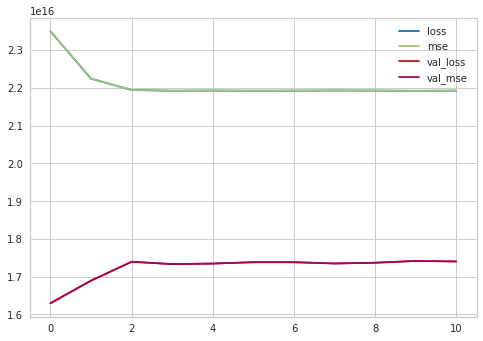

In [117]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate = 0.5)
# $CHALLENGIFY_BEGIN
model = compile_model(initialize_model(), 'adam')

es = EarlyStopping(patience =10,
                   restore_best_weights = True)

history = model.fit(X.dropna(), 
                    target_1, 
                    validation_split = 0.2,
                    shuffle = True,
                    batch_size = 32, 
                    epochs = 100, 
                    callbacks = [es], 
                    verbose=1)


pd.DataFrame(history.history).plot()

## 13- Prediction

In [123]:
# df_all_details.query("title in 'Titanic'")

id=597

record_clean=df_all_details.query("id==@id")
casting_clean= df_all_casting.query("id==@id")


,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
474,597,200000000,Drama|Romance|Thriller,tt0120338,en,Titanic,"84 years later, a 101-year-old woman named Ros...",10.517521,Paramount Pictures,United States of America,18/11/1997,1845034188,194.0,English,Released,Nothing on Earth could come between them.,Titanic,7.5,6844,3,1,6


In [124]:
df_all_casting.query("id==@id")

,id,actor1_name,actor1_gender,actor2_name,actor2_gender,actor3_name,actor3_gender,actor4_name,actor4_gender,actor5_name,actor5_gender,actor_number,director_name,director_gender,director_number,producer_name,producer_number,screeplay_name,editor_name
474,597,Kate Winslet,1,Leonardo DiCaprio,2.0,Frances Fisher,1,Billy Zane,2,Kathy Bates,1,136,James Cameron,2.0,1,James Cameron,2,James Cameron,Conrad Buff IV


## 13- Finding similar movies

In [125]:
X_processed

,cat_tr__day_of_week_0.0,cat_tr__day_of_week_1.0,cat_tr__day_of_week_2.0,cat_tr__day_of_week_3.0,cat_tr__day_of_week_4.0,cat_tr__day_of_week_5.0,cat_tr__day_of_week_6.0,cat_tr__day_of_week_nan,cat_imputer__day_of_week,cat_imputer__actor1_name,cat_imputer__actor2_name,cat_imputer__actor3_name,...,remainder__history,remainder__horror,remainder__movie,remainder__music,remainder__mystery,remainder__none,remainder__romance,remainder__science,remainder__thriller,remainder__tv,remainder__war,remainder__western
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8653,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8655,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [97]:
X_processed=preprocessor.fit_transform()


In [99]:
X

,budget,original_language,production_countries,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,sin_month,cos_month,action,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1,98.0,1,2,1,0.0,30.0,-5.000000e-01,8.660254e-01,0,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,0,110.0,1,3,2,4.0,32.0,-1.000000e+00,-1.836970e-16,1,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,1,121.0,1,2,1,2.0,48.0,8.660254e-01,-5.000000e-01,1,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,1,100.0,1,1,1,4.0,22.0,8.660254e-01,-5.000000e-01,0,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,1,142.0,1,1,1,2.0,31.0,1.224647e-16,-1.000000e+00,0,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0,-999.0,0,1,1,0.0,8.0,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,1,10.0,0,1,3,0.0,9.0,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0,-999.0,0,0,1,NaN,-999.0,-9.990000e+02,-9.990000e+02,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0,108.0,0,3,1,3.0,9.0,-5.000000e-01,8.660254e-01,1,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


In [115]:
from sklearn.neighbors import KNeighborsRegressor

# Define X and y
knn_model = KNeighborsRegressor().fit(X_processed,X_processed.iloc[:,0]) # Instanciate and train model

# knn_model.kneighbors(queen_song.drop(columns=['name','artists']),n_neighbors=2) # Return the distances and index of the 2 closest points
# df.iloc[4295] # The closest point is the actual song, obviously

In [119]:
df_all_details.query("title in 'Titanic'")

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
474,597,200000000,Drama|Romance|Thriller,tt0120338,en,Titanic,"84 years later, a 101-year-old woman named Ros...",10.517521,Paramount Pictures,United States of America,18/11/1997,1845034188,194.0,English,Released,Nothing on Earth could come between them.,Titanic,7.5,6844,3,1,6
1808,2699,13000000,Action|Drama|Romance,tt0115392,en,Titanic,A story of the romances of two couples upon th...,0.747,American Zoetrope,Canada,17/11/1996,0,173.0,English,Released,NaN,Titanic,6.4,41,1,2,1
6101,11021,0,Action|History|Drama,tt0036443,de,Titanic,This little-known German film retells the true...,0.319117,Tobis Filmkunst,Germany,10/11/1943,0,85.0,Deutsch,Released,NaN,Titanic,6.2,12,1,1,1
10087,16535,0,Drama|Action|Romance,tt0046435,en,Titanic,"Unhappily married, Julia Sturges decides to go...",0.263647,Twentieth Century Fox Film Corporation,United States of America,11/04/1953,0,98.0,English,Released,TITANIC in Emotion...in Spectacle...in Climax....,Titanic,6.2,25,1,1,4
82223,124712,0,Drama,tt1869152,en,Titanic,An extraordinary re-telling of the doomed voya...,0.125394,Mid Atlantic Films,Hungary,21/03/2012,0,240.0,English,Released,NaN,Titanic,4.6,7,5,3,1
235589,357517,0,Drama,tt0143942,de,Titanic,NaN,0.003595,none,Germany,01/01/1984,0,NaN,Deutsch,Released,NaN,Titanic,0.0,0,0,1,1
317641,455679,0,NaN,NaN,pt,Titanic,NaN,0.0,none,none,NaN,0,NaN,none,Released,NaN,Titanic,0.0,0,0,0,0


In [ ]:
# Pass song to model, ask for 11 closest points, and unpack the corresponding indices to a list
ind_list = list(knn_model.kneighbors(queen_song.drop(columns=['name','artists']),n_neighbors=11)[1][0])

# Filter original dataframe with indices list and sort by tempo
df.iloc[ind_list, :].sort_values(by="tempo")

## 14- API

In [127]:
record_clean=df_all_details.query("id==@id")
casting_clean= df_all_casting.query("id==@id")

In [153]:
def tweak_details(df_all_details):
    return (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp","month"])
    
    )
    
def fame_func(data_awards_cleaned,director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

def tweak_cast(df_all_casting,df):
    return(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
    
def tweak_director(df_all_casting,df):
    return (#2- extracting director_weights
                    df_all_casting 
                    .melt(id_vars="id",value_vars=["director_name"])
                    .sort_values(by=["id","variable"])
                    .merge(df[["id","year"]],on="id",how="left")
                    .replace("NaN",np.NaN)
                    .replace("none",np.NaN)
                    .dropna()
                    .assign(unit=1)
                    .sort_values(by=["value","year"])
                    .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                    .drop(columns=["variable","value","year","unit"])
                    .merge(df_all_casting[["id","director_name"]],on="id",how="left")
    )
    
def data_awards_cleaned(df_awards):
    return (
        df_awards
                .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
                .groupby(["director_name", "year","outcome"])
                .count()
                .unstack()
                .fillna(0)
                .reset_index()
                .iloc[:,0:4]
                .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
                .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
                    won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
                    )
                .set_index(["director_name","year"])
            )
    
def tweak_data(df_all_casting,df_all_details):
    df=tweak_details(df_all_details)
    actors_df=tweak_cast(df_all_casting,df)
    director_df=tweak_director(df_all_casting,df)
    
    data_awards_cleaned=data_awards_cleaned(df_awards)
    df=(
    df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","spoken_languages_number"] )
    ).assign(
        fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(data_awards_cleaned,df_.director_name,df_.year),axis=1),
        fame_won= lambda df_:df_.apply(lambda df_:fame_func(data_awards_cleaned,df_.director_name,df_.year,stat=1),axis=1)
        
    ).drop(columns=["director_name","fiction","year"] )


    df_nulls=df.replace(-999,np.NAN)
    df
    
    return df,df_nulls

In [154]:
a,b=tweak_data(df_all_casting,df_all_details)

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [135]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp","month"])
    
    )
actors_df=(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )
director_df=(#2- extracting director_weights
    df_all_casting 
                .melt(id_vars="id",value_vars=["director_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("NaN",np.NaN)
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(director_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .drop(columns=["variable","value","year","unit"])
                .merge(df_all_casting[["id","director_name"]],on="id",how="left")
)

data_awards_cleaned=(
    df_awards
            .assign(outcome=lambda df_:df_["outcome"].replace(["2nd place", "3rd place"], "Won"))
            .groupby(["director_name", "year","outcome"])
            .count()
            .unstack()
            .fillna(0)
            .reset_index()
            .iloc[:,0:4]
            .pipe(lambda df_:pd.DataFrame(df_.values,columns=["director_name","year","nominated","won"]))
            .assign(nominated_cumsum = lambda df_: df_.groupby("director_name")["nominated"].transform(pd.Series.cumsum),
                won_cumsum = lambda df_: df_.groupby("director_name")["won"].transform(pd.Series.cumsum),
                )
            .set_index(["director_name","year"])
)
    

def fame_func(data_awards_cleaned,director,dt_,stat=0):

    try: 
        if stat==0:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).nominated_cumsum.values[0]
        else:
            return data_awards_cleaned.loc[director][data_awards_cleaned.loc[director].index<=dt_].tail(1).won_cumsum.values[0]
            
    except:
        return np.NaN

df=(
    df
    .merge(actors_df,on=['id'],how="left")
    .merge(director_df,on=['id'],how="left")
    .drop(columns=["id","genres","spoken_languages_number"] )
).assign(
    fame_nominated= lambda df_:df_.apply(lambda df_:fame_func(data_awards_cleaned,df_.director_name,df_.year),axis=1),
    fame_won= lambda df_:df_.apply(lambda df_:fame_func(data_awards_cleaned,df_.director_name,df_.year,stat=1),axis=1)
    
).drop(columns=["director_name","fiction","year"] )


df_nulls=df.replace(-999,np.NAN)
df

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,sin_month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,-5.000000e-01,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,-1.000000e+00,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,8.660254e-01,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,8.660254e-01,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,1.224647e-16,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,-999.0,0,1,1,0.0,8.0,5.000000e-01,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,5.000000e-01,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,-999.0,0,0,1,NaN,-999.0,-9.990000e+02,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,-5.000000e-01,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


In [156]:
b

,budget,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,sin_month,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
0,4000000,1,1.698000,1,4300000.0,98.0,1,2,1,0.0,30.0,-5.000000e-01,...,0,0,0,0,3.0,8.0,5.0,7.0,3.0,2.0,4.0,4.0
1,0,1,1.322870,0,12136938.0,110.0,1,3,2,4.0,32.0,-1.000000e+00,...,1,0,0,0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0
2,11000000,1,10.492614,1,775398007.0,121.0,1,2,1,2.0,48.0,8.660254e-01,...,0,0,0,0,1.0,3.0,1.0,2.0,6.0,3.0,6.0,3.0
3,94000000,1,9.915573,1,940335536.0,100.0,1,1,1,4.0,22.0,8.660254e-01,...,0,0,0,0,4.0,1.0,1.0,19.0,1.0,2.0,9.0,8.0
4,55000000,1,10.351236,1,677945399.0,142.0,1,1,1,2.0,31.0,1.224647e-16,...,0,0,0,0,14.0,3.0,2.0,3.0,13.0,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,200,0,0.141433,0,200.0,NaN,0,1,1,0.0,8.0,5.000000e-01,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8653,1000,1,0.017510,1,700.0,10.0,0,1,3,0.0,9.0,5.000000e-01,...,0,0,0,0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
8654,800000,0,0.009000,0,40000.0,NaN,0,0,1,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8655,0,0,0.096195,0,640691.0,108.0,0,3,1,3.0,9.0,-5.000000e-01,...,0,0,0,0,NaN,NaN,1.0,2.0,2.0,2.0,5.0,17.0


In [158]:
df=    (#1- major cleanups
    df_all_details  
        .query("status in ['Released']")
        .pipe(lambda df_:df_.replace("none",np.NaN))
        .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
            genres=lambda df_:df_.genres.fillna("none"),
            runtime=lambda df_:df_.runtime.fillna(-999),
            # original_language=lambda df_:df_.original_language.fillna("none"),
            day_of_week_temp=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True),
            day_of_week=lambda f_:f_.day_of_week_temp.apply( lambda d:d.weekday()),
            year=lambda df_:pd.to_datetime(df_.release_date,dayfirst=True).dt.year,
            age=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
            month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
            sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
            cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
            popularity=lambda df_:df_.popularity.apply(lambda x:x.replace(",","")).astype("float") ,
            original_language=lambda df_:df_.original_language.apply(lambda x:1 if x=="en" else 0),
            production_countries=lambda df_:df_.production_countries.apply(lambda x:1 if x=="United States of America" else 0),
            spoken_languages=lambda df_:df_.spoken_languages.apply(lambda x:1 if x=="English" else 0),
      
            )
        
        .dropna(subset="revenue")
        .query("revenue > 0")
        .reset_index(drop=True)
        .pipe(lambda df_:pd.concat([df_,
                                prep_data(df_.genres)],axis=1))
        .drop(columns=["imdb_id","original_title",
                    "overview","status","tagline","title","vote_average","vote_count",
                    "production_companies","release_date","day_of_week_temp","month"])
    
    )

/home/ashamsa/.pyenv/versions/lewagon/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [159]:
df.head()

,id,budget,genres,original_language,popularity,production_countries,revenue,runtime,spoken_languages,production_companies_number,production_countries_number,spoken_languages_number,...,history,horror,movie,music,mystery,none,romance,science,thriller,tv,war,western
0,5,4000000,Crime|Comedy,1,1.698000,1,4300000.0,98.0,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,Action|Thriller|Crime,1,1.322870,0,12136938.0,110.0,1,3,2,1,...,0,0,0,0,0,0,0,0,1,0,0,0
2,11,11000000,Adventure|Action|Science Fiction,1,10.492614,1,775398007.0,121.0,1,2,1,1,...,0,0,0,0,0,0,0,1,0,0,0,0
3,12,94000000,Animation|Family,1,9.915573,1,940335536.0,100.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0
4,13,55000000,Comedy|Drama|Romance,1,10.351236,1,677945399.0,142.0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0,0,0


In [176]:
# actors_df=
(#2- extracting actor_weights
            df_all_casting 
                .melt(id_vars="id",value_vars=["actor1_name","actor2_name","actor3_name","actor4_name","actor5_name"])
                .sort_values(by=["id","variable"])
                .merge(df[["id","year"]],on="id",how="left")
                .replace("none",np.NaN)
                .dropna()
                .assign(unit=1)
                .sort_values(by=["value","year"])
                .assign(actor_freq=lambda df_:df_.groupby("value").cumsum()["unit"])
                .pipe(lambda df_:pd.pivot(df_,values="actor_freq",columns="variable",index="id"))
                .reset_index()
            )

variable,id,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name
0,5,3.0,8.0,5.0,7.0,3.0
1,6,8.0,3.0,1.0,1.0,1.0
2,11,1.0,3.0,1.0,2.0,6.0
3,12,4.0,1.0,1.0,19.0,1.0
4,13,14.0,3.0,2.0,3.0,13.0
...,...,...,...,...,...,...
8423,467940,NaN,1.0,1.0,1.0,1.0
8424,468073,NaN,1.0,2.0,1.0,NaN
8425,468579,NaN,1.0,1.0,NaN,NaN
8426,468656,NaN,NaN,1.0,2.0,2.0


In [169]:
["id","year"]

['id', 'year']